In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive"

'Aditya_TAMU_MSCS (1).pdf'
 Aditya_TAMU_MSCS.pdf
 Aditya_TAMU_Resume.pdf
 AdityaTempTimeSheet.gsheet
 AI_Final_report.pdf
'AI Project'
 best_model.pth.tar
 Books
 cats_and_dogs_small
'Colab Notebooks'
 deep-person-reid.zip
'Dennis L. Kasper_ Anthony S. Fauci_ Stephen L. Hauser_ Dan L. Longo_ J. Larry Jameson_ Joseph Loscalzo - Harrison’s Principles of Internal Medicine, Twentieth Edition (Vol.1 & Vol.2) (2018, McGraw-Hill Education _ .pdf'
'Download Folder Sept 2018'
 epilight_cpp_new.pdf
'feature_test_gallery (1).mat'
'feature_test_gallery (2).mat'
 feature_test_gallery.mat
'feature_test_query (1).mat'
'feature_test_query (2).mat'
 feature_test_query.mat
 G_10.pkl
 IMG_20180817_122408.jpg
 IMG_20180817_122409.jpg
 interview-preparation-best-100-ashay-raut.pdf
 MLOnAWS.pem
 MLOnAWS.ppk
'P&ID Basic'
 Practice.gdoc
 Rent
 SSN.pdf
'TAMU Study'
'Tuition TAMU'
 Untitled0.ipynb
'US VISA Docs'
'Weekly time sheet.gsheet'


In [4]:
!pwd

/content


In [0]:
# Import the files for training/testing

import os, shutil

base_dir = '/content/drive/My Drive/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')


In [6]:
# Confirming the sets

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))


total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [7]:
#  Instantiating the VGG16 convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step


In [8]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
# Defining the Neural Network Architecture
# Adding a densely connected classifier on top of the convolutional base
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [10]:
# The new architecture of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [14]:
# Frizing the convolutional base
conv_base.trainable = False
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [15]:
# Training the model end to end with a frozen convolutional base
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 29s 294ms/step - loss: 0.5976 - acc: 0.6930 - val_loss: 0.4584 - val_acc: 0.8140
Epoch 2/30
100/100 [==============================] - 26s 260ms/step - loss: 0.4854 - acc: 0.7790 - val_loss: 0.3949 - val_acc: 0.8220
Epoch 3/30
100/100 [==============================] - 26s 259ms/step - loss: 0.4242 - acc: 0.8095 - val_loss: 0.3363 - val_acc: 0.8600
Epoch 4/30
100/100 [==============================] - 26s 258ms/step - loss: 0.4055 - acc: 0.8180 - val_loss: 0.3100 - val_acc: 0.8760
Epoch 5/30
100/100 [==============================] - 26s 257ms/step - loss: 0.3905 - acc: 0.8250 - val_loss: 0.2992 - val_acc: 0.8700
Epoch 6/30
100/100 [==============================] - 26s 257ms/step - loss: 0.3729 - acc: 0.8420 - val_loss: 0.2837 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 25s 

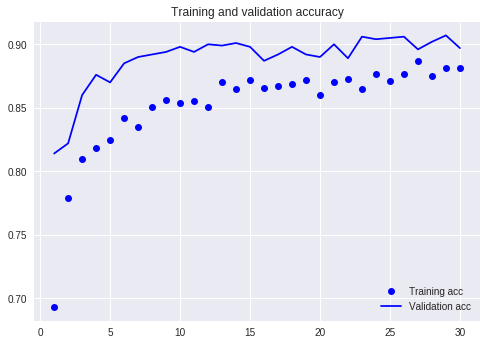

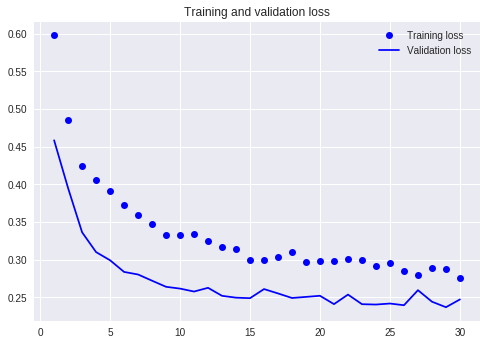

In [16]:
# Plotting the graph
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# Saving the model

model.save('cats_and_dogs_small_TL.h5')

In [18]:
# list of mertics that we saved
model.metrics_names

['loss', 'acc']

In [19]:
# make prediction on unseen data now - test data

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
prediction = model.evaluate_generator(test_generator, steps=50)


Found 1000 images belonging to 2 classes.


In [20]:
# metrics on the test data
prediction

[0.258378937159698, 0.8908629441624365]

In [0]:
# Fine Tuning the model
# Steps are:
# 1. Add your custom network on top of an already-trained base network.
# 2. Freeze the base network.
# 3. Train the part you added.
# 4. Unfreeze some layers in the base network.
# 5. Jointly train both these layers and the part you added.

# 1-3 already done

# Freezing all layers up to a specific one
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
#  Fine-tuning the model

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)


Epoch 1/100
100/100 [==============================] - 29s 289ms/step - loss: 0.2950 - acc: 0.8635 - val_loss: 0.2103 - val_acc: 0.9090
Epoch 2/100
100/100 [==============================] - 26s 263ms/step - loss: 0.2630 - acc: 0.8795 - val_loss: 0.2095 - val_acc: 0.9250
Epoch 3/100
100/100 [==============================] - 26s 265ms/step - loss: 0.2300 - acc: 0.9065 - val_loss: 0.2103 - val_acc: 0.9210
Epoch 4/100
100/100 [==============================] - 26s 263ms/step - loss: 0.2233 - acc: 0.9100 - val_loss: 0.1857 - val_acc: 0.9310
Epoch 5/100
100/100 [==============================] - 26s 262ms/step - loss: 0.2125 - acc: 0.9070 - val_loss: 0.2063 - val_acc: 0.9200
Epoch 6/100
100/100 [==============================] - 26s 262ms/step - loss: 0.1965 - acc: 0.9190 - val_loss: 0.2088 - val_acc: 0.9230
Epoch 7/100
100/100 [==============================] - 26s 262ms/step - loss: 0.1788 - acc: 0.9270 - val_loss: 0.1725 - val_acc: 0.9310
Epoch 8/100
100/100 [===========================

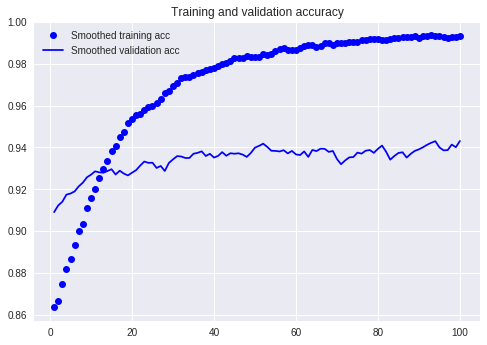

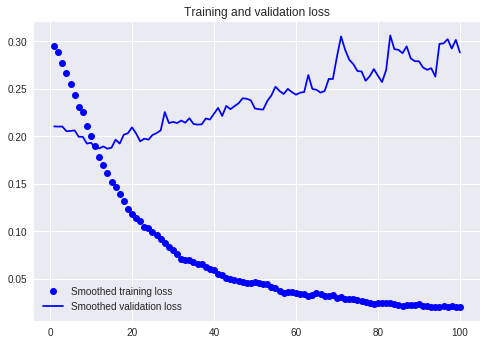

In [25]:
# Plot the curves to observe the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
# make prediction on unseen data now - test data

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
prediction = model.evaluate_generator(test_generator, steps=50)

Found 1000 images belonging to 2 classes.


In [26]:
# metrics on the test data
prediction

[0.33204299355566036, 0.9441624365482234]